In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import folium
import colorsys
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('gender_classification_v7.csv')
df.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   long_hair                  5001 non-null   int64  
 1   forehead_width_cm          5001 non-null   float64
 2   forehead_height_cm         5001 non-null   float64
 3   nose_wide                  5001 non-null   int64  
 4   nose_long                  5001 non-null   int64  
 5   lips_thin                  5001 non-null   int64  
 6   distance_nose_to_lip_long  5001 non-null   int64  
 7   gender                     5001 non-null   object 
dtypes: float64(2), int64(5), object(1)
memory usage: 312.7+ KB


In [5]:
df['gender'] =df['gender'].map({'Male': 0, 'Female': 1})

In [6]:
df.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,0
1,0,14.0,5.4,0,0,1,0,1
2,0,11.8,6.3,1,1,1,1,0
3,0,14.4,6.1,0,1,1,1,0
4,1,13.5,5.9,0,0,0,0,1


In [27]:
def showCorrelationOnData(data,*,threshold=None):
    sns.set_theme(style="white")
    corr = data.corr()
    if threshold:
        corr = data.corr()[(data.corr() >= threshold) | (data.corr() <= -threshold)]
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,square=True, linewidths=.5, \
                cbar_kws={"shrink": .5}, annot=True, annot_kws={"fontsize":12})
    plt.show()

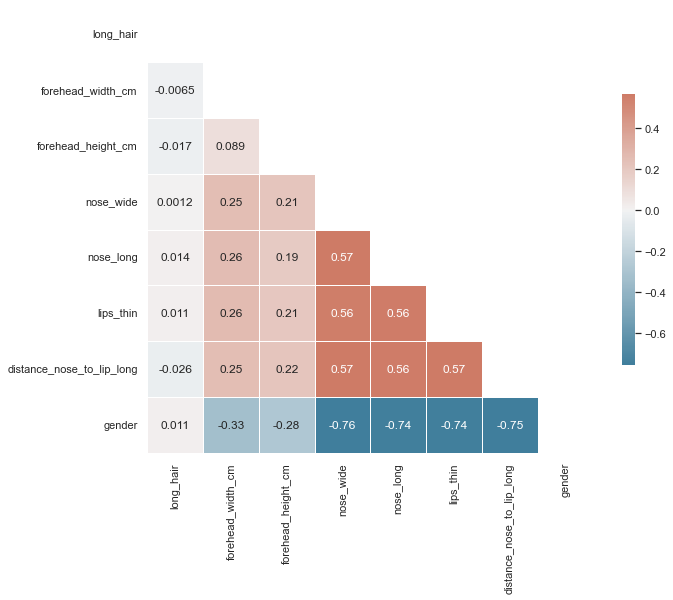

In [28]:
showCorrelationOnData(df)

In [9]:
# there are high negative linear correlation between 'gender' and ('nose_wide', 
# 'nose_long','lips_thin','distance_nose_to_lip_long')

In [11]:
all_features = df.columns.tolist()
target = all_features.pop()
all_features, target

(['long_hair',
  'forehead_width_cm',
  'forehead_height_cm',
  'nose_wide',
  'nose_long',
  'lips_thin',
  'distance_nose_to_lip_long'],
 'gender')

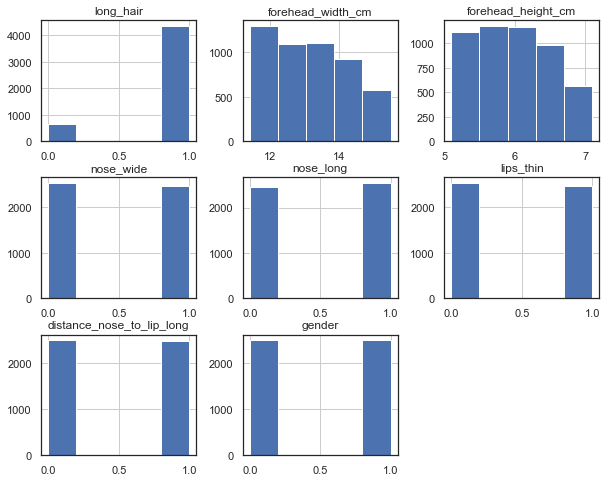

In [24]:
df.hist(bins=5,figsize=(10,8))
plt.show()

In [29]:
def checkImbalancedData(data,columnOfInterset):
    print(data[columnOfInterset].value_counts(normalize=True))
checkImbalancedData(df,'gender')

1    0.5001
0    0.4999
Name: gender, dtype: float64


In [30]:
# data semi balanced

In [31]:
def splitData(data,columnOfinterset,*,normalize = False):
    x = data.drop(columnOfinterset,axis=1).values
    y = data[columnOfinterset].values
    y = y.reshape(-1,1)
    if normalize:
        scaler = MinMaxScaler()
        scaler.fit(x)
        x = scaler.fit_transform(x)
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=1)
    return x_train,x_test,y_train,y_test

def checkShape(*args):
    for arg in args:
        print(arg.shape)
        
X_train,X_test,y_train,y_test = splitData(df,'gender',normalize=True)
checkShape(X_train,X_test,y_train,y_test)

(3350, 7)
(1651, 7)
(3350, 1)
(1651, 1)


In [32]:
def classificationAnalysis(model,x1,x2,y1,y2):
    def ClassficationMetricsReport(y1,y2,*,kind='test'):
        error_1 = accuracy_score(y1,y2)
        error_2 = f1_score(y1,y2)
        error_3 = precision_score(y1,y2)
        error_4 = recall_score(y1,y2)
        print(f'\t\taccuracy_score({kind}): {100*error_1:0.3f}%')
        print(f'\t\tf1_score({kind}): {100*error_2:0.3f}%')
        print(f'\t\tprecision_score({kind}): {100*error_3:0.3f}%')
        print(f'\t\trecall_score({kind}): {100*error_4:0.3f}%')
    model.fit(x1,y1)
    y1_pred = model.predict(x1)
    y2_pred = model.predict(x2)
    print(f'----{model.__class__.__name__} classification-------\n')
    print('\t----Train Error-------\n')
    ClassficationMetricsReport(y1_pred,y1,kind='train')
    print()
    print('\t----Test Error-------\n')
    ClassficationMetricsReport(y2_pred,y2)
    print()
    print()

In [34]:
knn = KNeighborsClassifier(n_neighbors=7)
reg = LogisticRegression()
dt = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
svm_model = svm.SVC()
algs = [knn, reg, dt, random_forest, svm_model]

In [35]:
reports = []
for alg in algs:
    reports.append(classificationAnalysis(alg,X_train,X_test,y_train,y_test))

C:\Users\amira\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\amira\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\amira\AppData\Local\Temp\ipykernel_9400\1508969543.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x1,y1)


----KNeighborsClassifier classification-------

	----Train Error-------

		accuracy_score(train): 97.045%
		f1_score(train): 97.075%
		precision_score(train): 97.798%
		recall_score(train): 96.364%

	----Test Error-------

		accuracy_score(test): 96.608%
		f1_score(test): 96.631%
		precision_score(test): 97.808%
		recall_score(test): 95.482%


----LogisticRegression classification-------

	----Train Error-------

		accuracy_score(train): 96.746%
		f1_score(train): 96.759%
		precision_score(train): 96.845%
		recall_score(train): 96.673%

	----Test Error-------

		accuracy_score(test): 96.972%
		f1_score(test): 96.951%
		precision_score(test): 96.833%
		recall_score(test): 97.070%


----DecisionTreeClassifier classification-------

	----Train Error-------

		accuracy_score(train): 99.881%
		f1_score(train): 99.881%
		precision_score(train): 99.821%
		recall_score(train): 99.940%

	----Test Error-------

		accuracy_score(test): 96.548%
		f1_score(test): 96.531%
		precision_score(test): 96

C:\Users\amira\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
def ClassficationMetricsReportd(y1,y2,*,kind='test'):
    error_1 = accuracy_score(y1,y2)
    error_2 = f1_score(y1,y2)
    error_3 = precision_score(y1,y2)
    error_4 = recall_score(y1,y2)
    return {'accuracy_score': 100*error_1,'f1_score': 100*error_2,'precision_score': 100*error_3,'recall_score': 100*error_4}
def classificationAnalysisd(model,x1,x2,y1,y2):
    model.fit(x1,y1)
    y1_pred = model.predict(x1)
    y2_pred = model.predict(x2)
    dictionary_report = {}
    dictionary_report [model.__class__.__name__ + "_Train Error"] = ClassficationMetricsReportd(y1_pred,y1,kind='train')
    dictionary_report [model.__class__.__name__ + "_Test Error"] = ClassficationMetricsReportd(y2_pred,y2)
    return dictionary_report
 

In [37]:
reports_ = []
for alg in algs:
    reports_.append(classificationAnalysisd(alg,X_train,X_test,y_train,y_test))

C:\Users\amira\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\amira\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\amira\AppData\Local\Temp\ipykernel_9400\3451258700.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x1,y1)
C:\Users\amira\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

In [38]:
reports_

[{'KNeighborsClassifier_Train Error': {'accuracy_score': 97.04477611940298,
   'f1_score': 97.07533234859675,
   'precision_score': 97.79761904761905,
   'recall_score': 96.36363636363636},
  'KNeighborsClassifier_Test Error': {'accuracy_score': 96.60811629315566,
   'f1_score': 96.63056558363417,
   'precision_score': 97.80755176613886,
   'recall_score': 95.48156956004756}},
 {'LogisticRegression_Train Error': {'accuracy_score': 96.74626865671641,
   'f1_score': 96.7588462682129,
   'precision_score': 96.8452380952381,
   'recall_score': 96.67260843731432},
  'LogisticRegression_Test Error': {'accuracy_score': 96.97153240460327,
   'f1_score': 96.95121951219512,
   'precision_score': 96.83313032886723,
   'recall_score': 97.06959706959707}},
 {'DecisionTreeClassifier_Train Error': {'accuracy_score': 99.88059701492537,
   'f1_score': 99.88088147706968,
   'precision_score': 99.82142857142857,
   'recall_score': 99.94040524433849},
  'DecisionTreeClassifier_Test Error': {'accuracy_scor

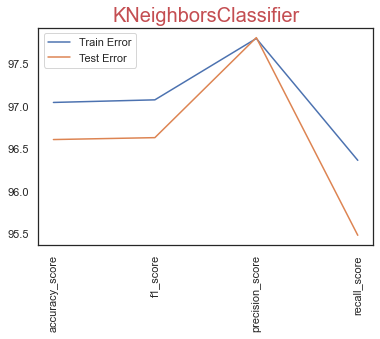

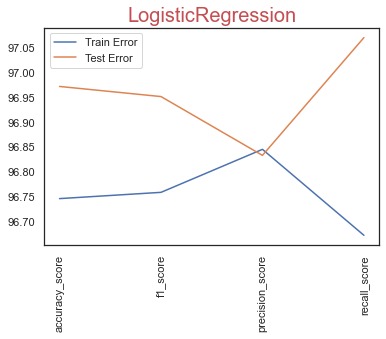

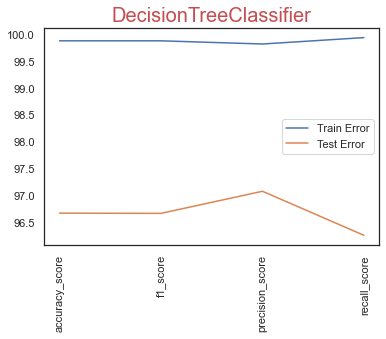

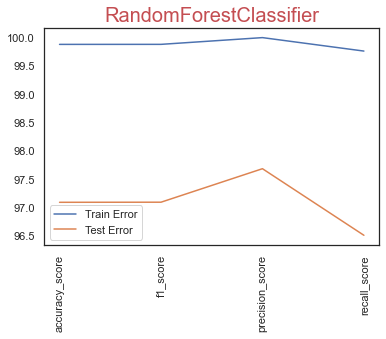

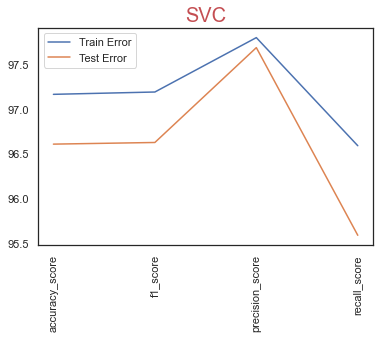

In [50]:
for n in range(len(algs)):
    # plt.figure(figsize=(8,8))
    plt.plot(list(reports_[n].values())[0].keys(), list(reports_[n].values())[0].values(),label='Train Error')
    plt.plot(list(reports_[n].values())[1].keys(), list(reports_[n].values())[1].values(),label='Test Error')
    plt.xticks(rotation = 90)
    title = list(reports_[n].keys())[0].split("_")[0]
    plt.title(title,fontdict={'fontsize':20},color='r')
    plt.legend()
    plt.show()

In [45]:
# details Support Vector Machine
svm_model = svm.SVC()
svm_model.fit(X_train,y_train)
y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_pred_svm,y_test))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       812
           1       0.98      0.96      0.97       839

    accuracy                           0.97      1651
   macro avg       0.97      0.97      0.97      1651
weighted avg       0.97      0.97      0.97      1651



C:\Users\amira\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
confusion_matrix(y_pred_svm,y_test)

array([[793,  19],
       [ 37, 802]], dtype=int64)

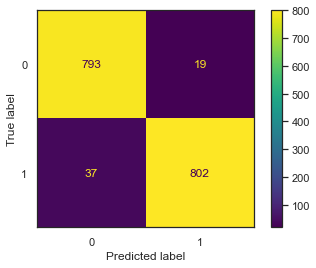

In [43]:
cm = confusion_matrix(y_pred_svm,y_test, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm_model.classes_)
disp.plot()
plt.show()